In [ ]:

# Cell 1:modules

import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader, TensorDataset
from sklearn.metrics import precision_recall_fscore_support, average_precision_score
import matplotlib.pyplot as plt

In [ ]:

# Cell 2: Data generation

np.random.seed(42)

n_timesteps = 5000
n_features = 10
anomaly_fraction = 0.03  # 3%

# Base multivariate AR(1)-like process for temporal correlation
data = np.zeros((n_timesteps, n_features))
phi = 0.8  # temporal correlation
cov = 0.1 * np.eye(n_features)  # cross-feature covariance

for t in range(1, n_timesteps):
    noise = np.random.multivariate_normal(mean=np.zeros(n_features), cov=cov)
    data[t] = phi * data[t-1] + noise

# Inject subtle anomalies
labels = np.zeros(n_timesteps, dtype=int)

n_anomalies = int(anomaly_fraction * n_timesteps)
anomaly_indices = np.random.choice(np.arange(50, n_timesteps), size=n_anomalies, replace=False)

for idx in anomaly_indices:
    # Apply structured change: shift some features and add local variance burst
    affected_features = np.random.choice(n_features, size=3, replace=False)
    data[idx, affected_features] += np.random.uniform(2.0, 3.0, size=3)
    if idx + 1 < n_timesteps:
        data[idx + 1, affected_features] += np.random.uniform(1.0, 2.0, size=3)
    labels[idx] = 1

# Normalize data
mean = data.mean(axis=0)
std = data.std(axis=0) + 1e-6
data_norm = (data - mean) / std

print("Data shape:", data_norm.shape)
print("Anomaly ratio:", labels.mean())

Data shape: (5000, 10)
Anomaly ratio: 0.03


In [ ]:

# Cell 3: Train / test split

indices = np.arange(n_timesteps)
np.random.shuffle(indices)

train_size = int(0.7 * n_timesteps)
train_idx = indices[:train_size]
test_idx = indices[train_size:]

X_train = data_norm[train_idx]
y_train = labels[train_idx]

X_test = data_norm[test_idx]
y_test = labels[test_idx]

# Optionally keep training set mostly normal by filtering anomalies out of train
normal_train_mask = y_train == 0
X_train = X_train[normal_train_mask]
y_train = y_train[normal_train_mask]

print("Train shape:", X_train.shape, "Test shape:", X_test.shape)
print("Train anomaly ratio:", y_train.mean(), "Test anomaly ratio:", y_test.mean())

Train shape: (3396, 10) Test shape: (1500, 10)
Train anomaly ratio: 0.0 Test anomaly ratio: 0.030666666666666665


In [ ]:

# Cell 4: PyTorch datasets

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)

X_train_t = torch.tensor(X_train, dtype=torch.float32)
X_test_t = torch.tensor(X_test, dtype=torch.float32)
y_test_t = torch.tensor(y_test, dtype=torch.int64)

batch_size = 128

train_ds = TensorDataset(X_train_t)
test_ds = TensorDataset(X_test_t, y_test_t)

train_loader = DataLoader(train_ds, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_ds, batch_size=batch_size, shuffle=False)

Using device: cpu


In [ ]:

# Cell 5: VAE model

input_dim = n_features
hidden_dim = 32
latent_dim = 4   # will tune later
beta = 1.0       # beta-VAE weight (will tune later)

class VAE(nn.Module):
    def __init__(self, input_dim, hidden_dim, latent_dim):
        super().__init__()
        # Encoder
        self.fc1 = nn.Linear(input_dim, hidden_dim)
        self.fc_mu = nn.Linear(hidden_dim, latent_dim)
        self.fc_logvar = nn.Linear(hidden_dim, latent_dim)
        # Decoder
        self.fc2 = nn.Linear(latent_dim, hidden_dim)
        self.fc3 = nn.Linear(hidden_dim, input_dim)

    def encode(self, x):
        h = F.relu(self.fc1(x))
        mu = self.fc_mu(h)
        logvar = self.fc_logvar(h)
        return mu, logvar

    def reparameterize(self, mu, logvar):
        std = torch.exp(0.5 * logvar)
        eps = torch.randn_like(std)
        return mu + eps * std

    def decode(self, z):
        h = F.relu(self.fc2(z))
        x_recon = self.fc3(h)  # regression-style reconstruction (MSE)
        return x_recon

    def forward(self, x):
        mu, logvar = self.encode(x)
        z = self.reparameterize(mu, logvar)
        x_recon = self.decode(z)
        return x_recon, mu, logvar

def vae_loss(x, x_recon, mu, logvar, beta=1.0):
    recon_loss = F.mse_loss(x_recon, x, reduction='mean')
    # KL divergence between q(z|x) and N(0, I)
    kl = -0.5 * torch.mean(1 + logvar - mu.pow(2) - logvar.exp())
    return recon_loss + beta * kl, recon_loss, kl

vae = VAE(input_dim, hidden_dim, latent_dim).to(device)
optimizer_vae = torch.optim.Adam(vae.parameters(), lr=1e-3)

In [ ]:

# Cell 6: Train VAE

n_epochs = 50

for epoch in range(1, n_epochs + 1):
    vae.train()
    total_loss = 0.0
    total_recon = 0.0
    total_kl = 0.0
    for (x_batch,) in train_loader:
        x_batch = x_batch.to(device)
        optimizer_vae.zero_grad()
        x_recon, mu, logvar = vae(x_batch)
        loss, recon_loss, kl_loss = vae_loss(x_batch, x_recon, mu, logvar, beta=beta)
        loss.backward()
        optimizer_vae.step()

        total_loss += loss.item() * x_batch.size(0)
        total_recon += recon_loss.item() * x_batch.size(0)
        total_kl += kl_loss.item() * x_batch.size(0)

    avg_loss = total_loss / len(train_loader.dataset)
    avg_recon = total_recon / len(train_loader.dataset)
    avg_kl = total_kl / len(train_loader.dataset)
    if epoch % 10 == 0 or epoch == 1:
        print(f"Epoch {epoch}: loss={avg_loss:.4f}, recon={avg_recon:.4f}, kl={avg_kl:.4f}")

Epoch 1: loss=0.9167, recon=0.8851, kl=0.0316
Epoch 10: loss=0.8479, recon=0.8443, kl=0.0035
Epoch 20: loss=0.8458, recon=0.8443, kl=0.0015
Epoch 30: loss=0.8457, recon=0.8448, kl=0.0009
Epoch 40: loss=0.8455, recon=0.8450, kl=0.0005
Epoch 50: loss=0.8458, recon=0.8454, kl=0.0004


In [ ]:

# Cell 7: Baseline AE

class AE(nn.Module):
    def __init__(self, input_dim, hidden_dim, latent_dim):
        super().__init__()
        self.encoder = nn.Sequential(
            nn.Linear(input_dim, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, latent_dim),
            nn.ReLU()
        )
        self.decoder = nn.Sequential(
            nn.Linear(latent_dim, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, input_dim)
        )

    def forward(self, x):
        z = self.encoder(x)
        x_recon = self.decoder(z)
        return x_recon

ae = AE(input_dim, hidden_dim, latent_dim).to(device)
optimizer_ae = torch.optim.Adam(ae.parameters(), lr=1e-3)
criterion_ae = nn.MSELoss()

n_epochs_ae = 50

for epoch in range(1, n_epochs_ae + 1):
    ae.train()
    total_loss = 0.0
    for (x_batch,) in train_loader:
        x_batch = x_batch.to(device)
        optimizer_ae.zero_grad()
        x_recon = ae(x_batch)
        loss = criterion_ae(x_recon, x_batch)
        loss.backward()
        optimizer_ae.step()
        total_loss += loss.item() * x_batch.size(0)
    avg_loss = total_loss / len(train_loader.dataset)
    if epoch % 10 == 0 or epoch == 1:
        print(f"AE Epoch {epoch}: loss={avg_loss:.4f}")

AE Epoch 1: loss=0.8465
AE Epoch 10: loss=0.5134
AE Epoch 20: loss=0.4921
AE Epoch 30: loss=0.4807
AE Epoch 40: loss=0.4723
AE Epoch 50: loss=0.4673


In [ ]:

# Cell 8: Evaluate and compute PR metrics

def compute_reconstruction_errors(model, loader, is_vae=False):
    model.eval()
    all_errors = []
    all_labels = []
    with torch.no_grad():
        for x_batch, y_batch in loader:
            x_batch = x_batch.to(device)
            if is_vae:
                x_recon, _, _ = model(x_batch)
            else:
                x_recon = model(x_batch)
            errors = torch.mean((x_batch - x_recon) ** 2, dim=1).cpu().numpy()
            all_errors.append(errors)
            all_labels.append(y_batch.numpy())
    return np.concatenate(all_errors), np.concatenate(all_labels)

vae_errors, labels_eval = compute_reconstruction_errors(vae, test_loader, is_vae=True)
ae_errors, _ = compute_reconstruction_errors(ae, test_loader, is_vae=False)

# Choose threshold from validation-style rule: e.g., 95th percentile of VAE error on train normals
with torch.no_grad():
    vae.train(False)
    train_errors = []
    for (x_batch,) in train_loader:
        x_batch = x_batch.to(device)
        x_recon, _, _ = vae(x_batch)
        e = torch.mean((x_batch - x_recon) ** 2, dim=1).cpu().numpy()
        train_errors.append(e)
    train_errors = np.concatenate(train_errors)

threshold = np.percentile(train_errors, 95)
print("Chosen reconstruction error threshold:", float(threshold))

# Predictions: anomaly if error > threshold
vae_pred = (vae_errors > threshold).astype(int)
ae_pred = (ae_errors > np.percentile(ae_errors, 95)).astype(int)  # similar rule

# Metrics
def compute_metrics(pred, true, scores):
    precision, recall, f1, _ = precision_recall_fscore_support(true, pred, average='binary', zero_division=0)
    auprc = average_precision_score(true, scores)
    return precision, recall, f1, auprc

vae_p, vae_r, vae_f1, vae_auprc = compute_metrics(vae_pred, labels_eval, vae_errors)
ae_p, ae_r, ae_f1, ae_auprc = compute_metrics(ae_pred, labels_eval, ae_errors)

print("VAE  -> Precision:", vae_p, "Recall:", vae_r, "F1:", vae_f1, "AUPRC:", vae_auprc)
print("AE   -> Precision:", ae_p, "Recall:", ae_r, "F1:", ae_f1, "AUPRC:", ae_auprc)
print("Final VAE threshold (deliverable):", float(threshold))

Chosen reconstruction error threshold: 1.6286771297454834
VAE  -> Precision: 0.42592592592592593 Recall: 1.0 F1: 0.5974025974025974 AUPRC: 0.9903724740810936
AE   -> Precision: 0.6133333333333333 Recall: 1.0 F1: 0.7603305785123967 AUPRC: 0.9315909619735574
Final VAE threshold (deliverable): 1.6286771297454834


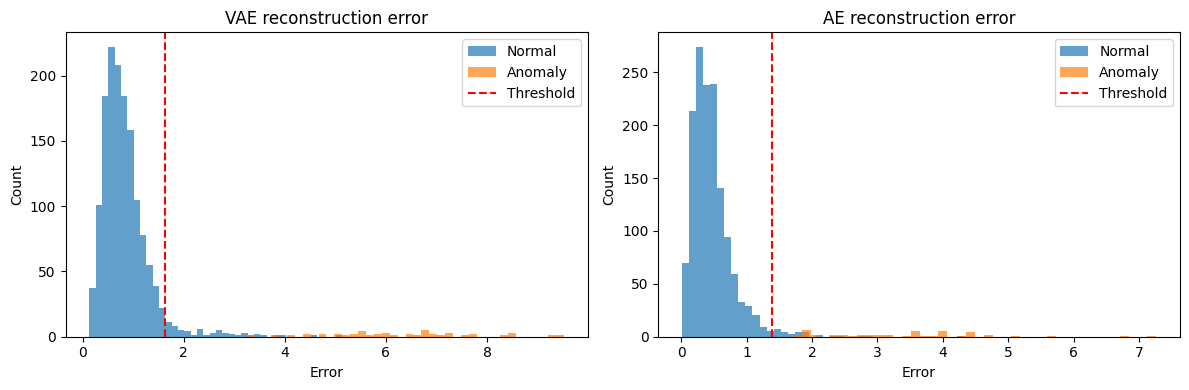

In [ ]:
# Cell: Histograms of reconstruction error (VAE vs AE)
import matplotlib.pyplot as plt
plt.figure(figsize=(12,4))

plt.subplot(1,2,1)
plt.hist(vae_errors[y_test == 0], bins=40, alpha=0.7, label='Normal')
plt.hist(vae_errors[y_test == 1], bins=40, alpha=0.7, label='Anomaly')
plt.axvline(threshold, color='red', linestyle='--', label='Threshold')
plt.title("VAE reconstruction error")
plt.xlabel("Error")
plt.ylabel("Count")
plt.legend()

plt.subplot(1,2,2)
ae_thr = np.percentile(ae_errors, 95)
plt.hist(ae_errors[y_test == 0], bins=40, alpha=0.7, label='Normal')
plt.hist(ae_errors[y_test == 1], bins=40, alpha=0.7, label='Anomaly')
plt.axvline(ae_thr, color='red', linestyle='--', label='Threshold')
plt.title("AE reconstruction error")
plt.xlabel("Error")
plt.ylabel("Count")
plt.legend()

plt.tight_layout()
plt.show()

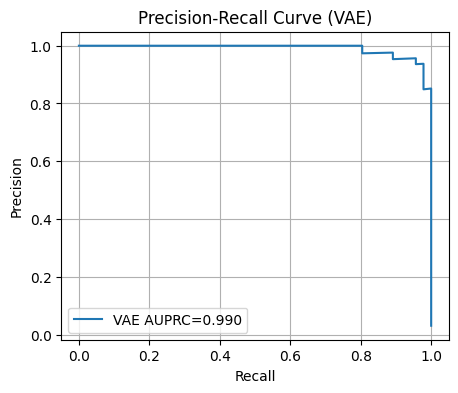

In [ ]:

# Cell 9: Simple AUPRC curve data (for VAE)

from sklearn.metrics import precision_recall_curve

precision_curve, recall_curve, pr_thresholds = precision_recall_curve(labels_eval, vae_errors)

plt.figure(figsize=(5,4))
plt.plot(recall_curve, precision_curve, label=f"VAE AUPRC={vae_auprc:.3f}")
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.title("Precision-Recall Curve (VAE)")
plt.legend()
plt.grid(True)
plt.show()

In [ ]:

# Cell 10: Simple hyperparameter search (small grid)

latent_dims = [2, 4, 8]
betas = [0.5, 1.0, 2.0]

results = []

for ld in latent_dims:
    for b in betas:
        print(f"\nTraining VAE with latent_dim={ld}, beta={b}")
        vae_tmp = VAE(input_dim, hidden_dim, ld).to(device)
        opt_tmp = torch.optim.Adam(vae_tmp.parameters(), lr=1e-3)

        for epoch in range(1, 21):  # fewer epochs for speed
            vae_tmp.train()
            for (x_batch,) in train_loader:
                x_batch = x_batch.to(device)
                opt_tmp.zero_grad()
                x_recon, mu, logvar = vae_tmp(x_batch)
                loss, _, _ = vae_loss(x_batch, x_recon, mu, logvar, beta=b)
                loss.backward()
                opt_tmp.step()

        # Evaluate AUPRC on test
        errors_tmp, _ = compute_reconstruction_errors(vae_tmp, test_loader, is_vae=True)
        # Use same 95 percentile rule from train normals
        train_errors_tmp = []
        with torch.no_grad():
            for (x_batch,) in train_loader:
                x_batch = x_batch.to(device)
                x_recon, mu, logvar = vae_tmp(x_batch)
                e = torch.mean((x_batch - x_recon) ** 2, dim=1).cpu().numpy()
                train_errors_tmp.append(e)
        train_errors_tmp = np.concatenate(train_errors_tmp)
        thr_tmp = np.percentile(train_errors_tmp, 95)

        pred_tmp = (errors_tmp > thr_tmp).astype(int)
        p, r, f1, auprc_tmp = compute_metrics(pred_tmp, labels_eval, errors_tmp)

        print(f"latent_dim={ld}, beta={b} -> F1={f1:.3f}, AUPRC={auprc_tmp:.3f}")
        results.append((ld, b, f1, auprc_tmp))

print("\nHyperparameter results (latent_dim, beta, F1, AUPRC):")
for r in results:
    print(r)


Training VAE with latent_dim=2, beta=0.5
latent_dim=2, beta=0.5 -> F1=0.597, AUPRC=0.990

Training VAE with latent_dim=2, beta=1.0
latent_dim=2, beta=1.0 -> F1=0.597, AUPRC=0.991

Training VAE with latent_dim=2, beta=2.0
latent_dim=2, beta=2.0 -> F1=0.609, AUPRC=0.990

Training VAE with latent_dim=4, beta=0.5
latent_dim=4, beta=0.5 -> F1=0.568, AUPRC=0.982

Training VAE with latent_dim=4, beta=1.0
latent_dim=4, beta=1.0 -> F1=0.609, AUPRC=0.991

Training VAE with latent_dim=4, beta=2.0
latent_dim=4, beta=2.0 -> F1=0.594, AUPRC=0.991

Training VAE with latent_dim=8, beta=0.5
latent_dim=8, beta=0.5 -> F1=0.582, AUPRC=0.907

Training VAE with latent_dim=8, beta=1.0
latent_dim=8, beta=1.0 -> F1=0.590, AUPRC=0.978

Training VAE with latent_dim=8, beta=2.0
latent_dim=8, beta=2.0 -> F1=0.590, AUPRC=0.991

Hyperparameter results (latent_dim, beta, F1, AUPRC):
(2, 0.5, 0.5974025974025974, np.float64(0.9903724740810936))
(2, 1.0, 0.5974025974025974, np.float64(0.9912044612104651))
(2, 2.0, 0.60